In [1]:
from preprocess import dataset,get_Kfold
from sklearn.preprocessing import MinMaxScaler
from models import MLP
from torch import optim
from torch.utils.data import DataLoader,Dataset
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import json
import random
from TrainandTest import train_MLP,test_MLP

def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(114514)

In [2]:
def get_models(model):
    if model=='MLP':
        return MLP(5,64)

def train_epoch(train_loader,model,criterion,optimizer,device):
    losses = []
    for i, (inputs, labels) in enumerate(train_loader):
        labels = labels.to(device)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))

        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    return sum(losses)/len(losses)

In [3]:
with open('config.json','r',encoding='utf-8')as f:
    config_list = json.load(f)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
file = './data/jiji small126.xlsx'
para_path = './save/parameter'
batch_size = 300
plot = True

-----------[ K:1 Type:odd N_size:<126 ]-----------
loss:10.989243507385254 saving...
loss:0.4072718918323517 saving...
loss:0.28314080834388733 saving...
loss:0.09626545011997223 saving...
loss:0.09433937817811966 saving...
loss:0.08131644129753113 saving...
loss:0.07349847257137299 saving...
loss:0.06612598896026611 saving...
loss:0.06279486417770386 saving...
loss:0.06258789449930191 saving...
loss:0.06250950694084167 saving...
loss:0.06242293119430542 saving...
loss:0.06230033561587334 saving...
loss:0.06226005405187607 saving...
loss:0.06225048750638962 saving...
Test Loss: 0.0736046433, Test RMSE: 0.2713017570


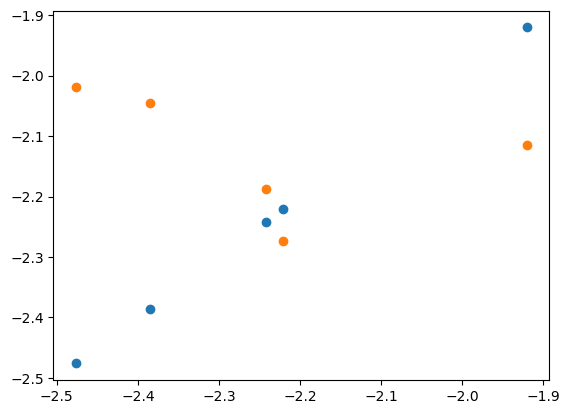

-----------[ K:2 Type:odd N_size:<126 ]-----------
loss:6.759664058685303 saving...
loss:0.5556251406669617 saving...
loss:0.09936190396547318 saving...
loss:0.07889817655086517 saving...
loss:0.0679396390914917 saving...
loss:0.06761171668767929 saving...
loss:0.06750497967004776 saving...
loss:0.06723641604185104 saving...
loss:0.06715378910303116 saving...
loss:0.06694295257329941 saving...
loss:0.06692571938037872 saving...
loss:0.06692557781934738 saving...
Test Loss: 0.0235804766, Test RMSE: 0.1535593587


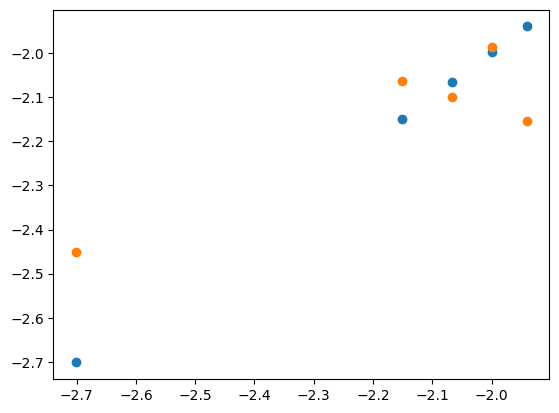

-----------[ K:3 Type:odd N_size:<126 ]-----------
loss:4.299267768859863 saving...
loss:0.5216898918151855 saving...
loss:0.42741790413856506 saving...
loss:0.17986175417900085 saving...
loss:0.14752064645290375 saving...
loss:0.08695914596319199 saving...
loss:0.0685221254825592 saving...
loss:0.06538327038288116 saving...
loss:0.06527124345302582 saving...
loss:0.0645158514380455 saving...
loss:0.06437603384256363 saving...
loss:0.06427612900733948 saving...
loss:0.06415721774101257 saving...
loss:0.06388407945632935 saving...
loss:0.06376627087593079 saving...
loss:0.06376131623983383 saving...
Test Loss: 0.0613485575, Test RMSE: 0.2476864095


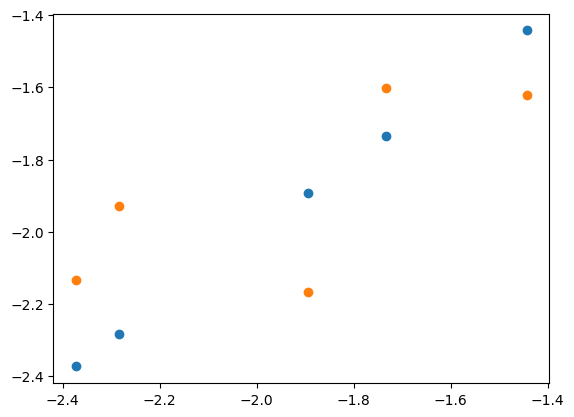

-----------[ K:4 Type:odd N_size:<126 ]-----------
loss:4.030195713043213 saving...
loss:0.499714195728302 saving...
loss:0.33095782995224 saving...
loss:0.25590524077415466 saving...
loss:0.17534169554710388 saving...
loss:0.07207546383142471 saving...
loss:0.06863947212696075 saving...
loss:0.06705913692712784 saving...
loss:0.06701197475194931 saving...
loss:0.06696166098117828 saving...
loss:0.06691786646842957 saving...
Test Loss: 0.0102634151, Test RMSE: 0.1013085142


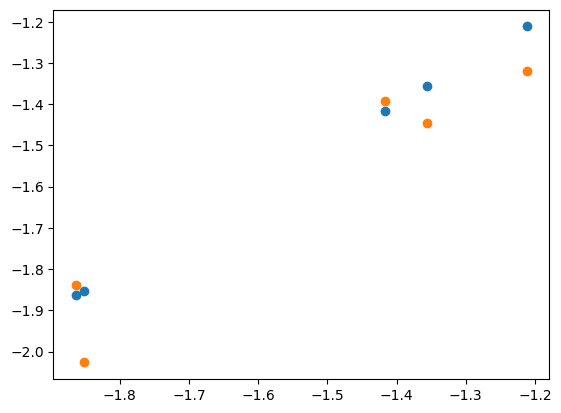

-----------[ K:5 Type:odd N_size:<126 ]-----------
loss:8.15199089050293 saving...
loss:0.39885491132736206 saving...
loss:0.33458733558654785 saving...
loss:0.29325056076049805 saving...
loss:0.16674502193927765 saving...
loss:0.13467049598693848 saving...
loss:0.10645928978919983 saving...
loss:0.06639589369297028 saving...
loss:0.06382270902395248 saving...
loss:0.06342101842164993 saving...
loss:0.06304933875799179 saving...
loss:0.06283804029226303 saving...
loss:0.061953622847795486 saving...
loss:0.061822373420000076 saving...
loss:0.06155725568532944 saving...
loss:0.061504218727350235 saving...
loss:0.06123668700456619 saving...
loss:0.06101742759346962 saving...
loss:0.060969024896621704 saving...
loss:0.06091231107711792 saving...
loss:0.06086910516023636 saving...
loss:0.060864243656396866 saving...
loss:0.06086406484246254 saving...
loss:0.06086091324687004 saving...
loss:0.06084953993558884 saving...
Test Loss: 0.1072426587, Test RMSE: 0.3274792493


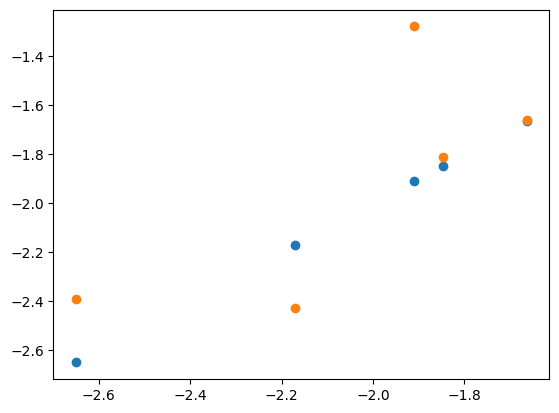

-----------[ K:6 Type:odd N_size:<126 ]-----------
loss:5.040853023529053 saving...
loss:0.7754213213920593 saving...
loss:0.44705790281295776 saving...
loss:0.34912723302841187 saving...
loss:0.27230381965637207 saving...
loss:0.1231653019785881 saving...
loss:0.07984306663274765 saving...
loss:0.07358413934707642 saving...
loss:0.07118863612413406 saving...
loss:0.06726771593093872 saving...
loss:0.06643342226743698 saving...
loss:0.06600972265005112 saving...
loss:0.06441282480955124 saving...
loss:0.0642569363117218 saving...
loss:0.06421684473752975 saving...
loss:0.06359730660915375 saving...
loss:0.0633782148361206 saving...
loss:0.06337817758321762 saving...
loss:0.0633670762181282 saving...
loss:0.06336016207933426 saving...
Test Loss: 0.0580064952, Test RMSE: 0.2408453762


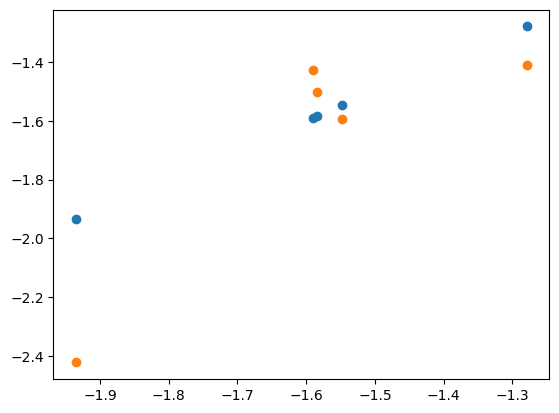

-----------[ K:7 Type:odd N_size:<126 ]-----------
loss:6.046975135803223 saving...
loss:0.31842440366744995 saving...
loss:0.1400766521692276 saving...
loss:0.07835681736469269 saving...
loss:0.07745584845542908 saving...
loss:0.06891519576311111 saving...
loss:0.06816443055868149 saving...
loss:0.06815967708826065 saving...
loss:0.06742586940526962 saving...
loss:0.06742506474256516 saving...
loss:0.0674181580543518 saving...
loss:0.06741534918546677 saving...
loss:0.06740924715995789 saving...
Test Loss: 0.0193774402, Test RMSE: 0.1392028743


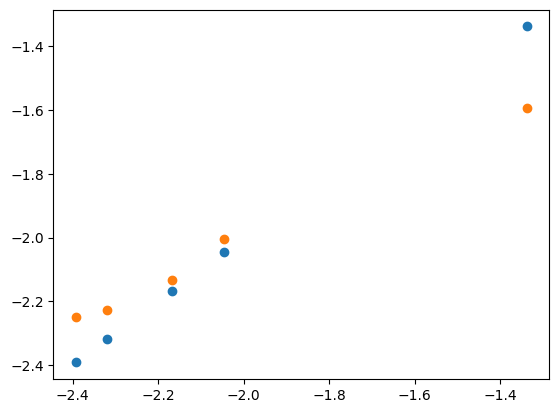

-----------[ K:8 Type:odd N_size:<126 ]-----------
loss:1.9430863857269287 saving...
loss:0.21810705959796906 saving...
loss:0.10515739768743515 saving...
loss:0.09144604206085205 saving...
loss:0.08548961579799652 saving...
loss:0.06790252029895782 saving...
loss:0.06473973393440247 saving...
loss:0.06398775428533554 saving...
loss:0.06372994184494019 saving...
loss:0.06368817389011383 saving...
loss:0.06363586336374283 saving...
loss:0.06360454112291336 saving...
Test Loss: 0.0598002672, Test RMSE: 0.2445409316


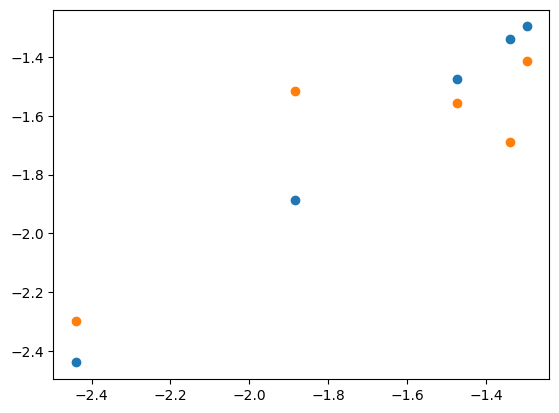

-----------[ K:9 Type:odd N_size:<126 ]-----------
loss:5.393927097320557 saving...
loss:0.6971620917320251 saving...
loss:0.34572499990463257 saving...
loss:0.19716812670230865 saving...
loss:0.07687654346227646 saving...
loss:0.0711052343249321 saving...
loss:0.06653991341590881 saving...
loss:0.06591122597455978 saving...
loss:0.06545206159353256 saving...
loss:0.06349240988492966 saving...
loss:0.06344997882843018 saving...
loss:0.06320661306381226 saving...
loss:0.06312458962202072 saving...
loss:0.06308982521295547 saving...
loss:0.06308425962924957 saving...
loss:0.06306597590446472 saving...
loss:0.06299997866153717 saving...
loss:0.06294874846935272 saving...
loss:0.06292770802974701 saving...
loss:0.06289492547512054 saving...
loss:0.06287562847137451 saving...
loss:0.06284540891647339 saving...
loss:0.06282314658164978 saving...
loss:0.06279893219470978 saving...
Test Loss: 0.0787249357, Test RMSE: 0.2805796423


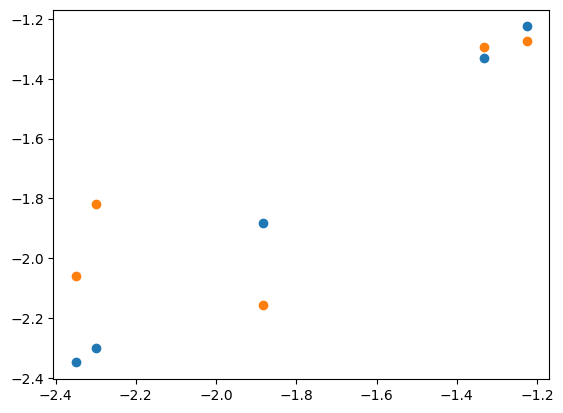

-----------[ K:10 Type:odd N_size:<126 ]-----------
loss:3.896409273147583 saving...
loss:0.4679590165615082 saving...
loss:0.10756490379571915 saving...
loss:0.08177224546670914 saving...
loss:0.06283829361200333 saving...
loss:0.05515248700976372 saving...
loss:0.0529903806746006 saving...
loss:0.04713830351829529 saving...
loss:0.04577260464429855 saving...
loss:0.04254159703850746 saving...
loss:0.04219341278076172 saving...
loss:0.04208001494407654 saving...
loss:0.04203924536705017 saving...
loss:0.04178654029965401 saving...
loss:0.04177200421690941 saving...
loss:0.041698895394802094 saving...
loss:0.04167851433157921 saving...
loss:0.04165765643119812 saving...
loss:0.04165007919073105 saving...
loss:0.04161993786692619 saving...
Test Loss: 0.3587257862, Test RMSE: 0.5989372139


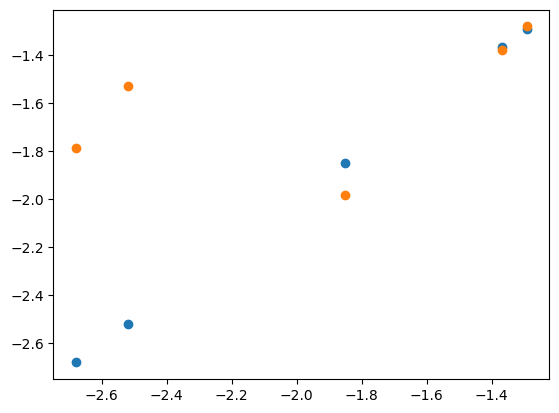

mean rmse of k fold is: 0.26054413270203425


In [4]:

for config in config_list:
    Type = config['Type']
    N_size = config['N_size']
    num_epoch = config['num_epoch']
    lr = config['lr']
    k = config['k']
    alpha,beta = config['alpha'],config['beta']
    
    K_fold_data = get_Kfold(file,k)
    
    rmse_list = []
    for k_step,(trian_data,test_data) in enumerate(K_fold_data):
        print(f"-----------[ K:{k_step+1} Type:{Type} N_size:{N_size} ]-----------")
        model = get_models(config['model']).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(),lr=lr)
        lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda x: 1 - x/num_epoch,last_epoch=-1)
        
        scaler = MinMaxScaler()
        trian_data = dataset(trian_data,Type,N_size)
        test_data = dataset(test_data,Type,N_size)
        
        train_loader = DataLoader(dataset=trian_data,batch_size=batch_size)
        test_loader = DataLoader(dataset=test_data,batch_size=batch_size)
        
        train_MLP(train_loader,model,criterion,optimizer,num_epoch,k_step,lr_scheduler,para_path)
        rmse = test_MLP(test_loader,model,k_step,criterion,plot,para_path)
        rmse_list.append(rmse)
    print(f"mean rmse of k fold is: {sum(rmse_list)/len(rmse_list)}")